In [1]:
import logging

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jupyter_black

jupyter_black.load()

In [4]:
from glicko2 import glicko2

glicko2.__file__

'/home/cpennington/projects/yomi-skill/.venv/lib/python3.10/site-packages/glicko2/glicko2.cpython-310-x86_64-linux-gnu.so'

In [5]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-11-01 13:59:56.453846: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-01 13:59:56 INFO     Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
2023-11-01 13:59:56 INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
2023-11-01 13:59:56 INFO     Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-11-01 13:59:56 WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [6]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.games.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

2023-11-01 14:00:02 WARNING  Using NumPy C-API based implementation for BLAS functions.


In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

In [8]:
fit_dir = tempfile.mkdtemp()

In [9]:
from yomi_skill.games.yomi2 import fetch_historical_record

record = fetch_historical_record()

In [10]:
import datetime

dt_matches = record[~(record.match_date.dt.time == datetime.time(0, 0))]
dt_matches["cluster"] = (
    dt_matches.match_date.sort_values()
    .diff()
    .gt(datetime.timedelta(minutes=1))
    .cumsum()
    .add(1)
)

dt_matches.drop_duplicates(
    ["cluster", "player_1", "player_2", "gem_1", "gem_2", "character_1", "character_2"]
)

/tmp/ipykernel_2373/1922672197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_matches["cluster"] = (


,match_date,player_1,character_1,gem_1,player_2,character_2,gem_2,winner,source,win,cluster
210,2023-09-09 03:28:20.804000+00:00,hobusu,lum,black,vengefulpickle,midori,green,P1,[_ 2455.518] FriendMatchOnline Game over: Remo...,True,1
212,2023-09-13 03:12:30.285000+00:00,SirHandsome,lum,red,vengefulpickle,argagarg,black,P1,[_ 2009.661] LiveOnline Game over: Remote P0 [...,True,2
213,2023-09-15 17:21:39.334000+00:00,AlmightyBotan,midori,green,moon,setsuki,black,P1,[_ 2102.451] FriendMatchOnline Game over: Loca...,True,3
214,2023-09-15 17:27:02.517000+00:00,AlmightyBotan,midori,green,moon,setsuki,black,P1,[_ 2425.634] FriendMatchOnline Game over: Loca...,True,4
215,2023-09-15 18:02:36.002000+00:00,AlmightyBotan,midori,purple,darkness,jaina,red,P1,[_ 4559.119] FriendMatchOnline Game over: Loca...,True,5
...,...,...,...,...,...,...,...,...,...,...,...
302,2023-10-21 13:44:37.844000+00:00,AlmightyBotan,midori,black,MollyWantsHugs,menelker,black,P2,[_ 1204.984] LiveOnline Game over: Local P0 [A...,False,72
306,2023-10-25 11:06:07.981000+00:00,AlmightyBotan,midori,black,PurpleInfinite,setsuki,blue,P2,[_ 617.749] LiveOnline Game over: Local P0 [Al...,False,73
307,2023-10-25 11:18:36.169000+00:00,AlmightyBotan,midori,black,PurpleInfinite,setsuki,blue,P1,[_ 1365.937] LiveOnline Game over: Local P0 [A...,True,74
308,2023-10-25 11:32:51.313000+00:00,AlmightyBotan,midori,black,PurpleInfinite,setsuki,blue,P2,[_ 2221.081] LiveOnline Game over: Local P0 [A...,False,75


# Set up games

In [11]:
tournament_games = historical_record.latest_tournament_games()
sirlin_games = historical_record.sirlin_db()
games = pandas.concat([tournament_games, sirlin_games]).reset_index(drop=True)

games = games

In [12]:
games = historical_record.augment_dataset(games)

Constructing PC category


# Set up models

In [13]:
min_games = 0
warmup = 500
samples = 1000

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    games,
    games.win.astype("int"),
)

In [15]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [16]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'mu_pc_elo_c': yomi_skill.models.mu_pc_elo_c.MUPCEloC,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'full_glicko_no_scale': yomi_skill.models.full_glicko_no_scale.FullGlickoNoScale,
 'mu_pc_elo_vol': yomi_skill.models.mu_pc_elo_vol.MUPCEloVol,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'full_glicko': yomi_skill.models.full_glicko.FullGlicko,
 'custom_glicko': yomi_skill.models.custom_glicko.CustomGlicko,
 'full': yomi_skill.models.full.Full,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_o

In [17]:
model_names = [
    # "full",
    # "full_glicko",
    "full_glicko_no_scale",
    # "custom_glicko",
    # 'mu',
    # 'elo',
    # 'mu_elo',
    # 'pc_elo',
    # 'mu_pc_elo',
    # 'mu_pc_elo_vol',
    # 'mu_pc_elo_c',
    # 'glicko',
    # 'mu_glicko',
    # 'pc_glicko',
    # 'mu_pc_glicko',
]
models = {
    model_name: MODELS[model_name](min_games=min_games, warmup=warmup, samples=samples)
    for model_name in model_names
}

In [18]:
parameters = {}
parameters["full"] = [
    dict(
        transform__elo__initial_time=games.match_date.min(),
        transform__pc_elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        transform__elo__default_k=16,
        transform__pc_elo__default_k=1,
    )
]

parameters["full_glicko"] = [
    dict(
        transform__glicko__initial_time=games.match_date.min(),
        transform__pc_glicko__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        transform__glicko__initial_value=(1500.0, 30, 0.09),
        transform__pc_glicko__initial_value=(1500.0, 50, 0.007),
    ),
    dict(
        transform__glicko__initial_time=games.match_date.min(),
        transform__pc_glicko__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        transform__glicko__initial_value=(1500.0, 40, 0.049),
        transform__pc_glicko__initial_value=(1500.0, 110, 0.081),
        transform__glicko__rating_period="1W",
        transform__pc_glicko__rating_period="2W",
    ),
    # dict(
    #     transform__glicko__initial_time=games.match_date.min(),
    #     transform__pc_glicko__initial_time=games.match_date.min(),
    #     model__min_games=min_games,
    #     model__warmup=warmup,
    #     model__samples=samples,
    #     transform__glicko__initial_value=(1500.0, 30, 0.09),
    #     transform__pc_glicko__initial_value=(1500.0, 50, 0.007),
    #     transform__glicko__rating_period="1D",
    #     transform__pc_glicko__rating_period="1D",
    # ),
]
parameters["full_glicko_no_scale"] = [
    dict(
        rating_periods__player__kw_args=dict(field_prefix="player", threshold=1),
        rating_periods__player_character__kw_args=dict(
            field_prefix="player_character", threshold=3
        ),
        transform__glicko__initial_time=games.match_date.min(),
        transform__pc_glicko__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        transform__glicko__initial_value=(1500.0, 60, 0.071),
        transform__pc_glicko__initial_value=(1500.0, 40, 0.084),
        transform__glicko__rating_period_field="player__period_idx",
        transform__pc_glicko__rating_period_field="player_character__period_idx",
    ),
]
parameters["custom_glicko"] = [
    dict(
        transform__glicko__initial_time=games.match_date.min(),
        transform__pc_glicko__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        # transform__glicko__initial_value=(1500.0, 30, 0.09),
        # transform__pc_glicko__initial_value=(1500.0, 50, 0.007),
    )
]
parameters["mu_elo"] = [
    dict(
        transform__elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
    )
]
parameters["mu_pc_elo"] = [
    dict(
        transform__pc_elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
    )
]

In [19]:
pipelines = {
    f"{model_name}-{idx}": MODELS[model_name].pipeline(**params)
    for model_name in model_names
    for idx, params in enumerate(parameters[model_name])
}

# Fit Models

In [20]:
for model_name in pipelines:
    if not hasattr(pipelines[model_name]["model"], "inf_data_"):
        pipelines[model_name].fit(
            X_train,
            y_train,
            # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
        )

2023-11-01 14:01:07 INFO     Starting Glicko2Estimator.fit
2023-11-01 14:01:24 INFO     Ending Glicko2Estimator.fit
2023-11-01 14:01:24 INFO     Starting Glicko2Estimator.transform
2023-11-01 14:01:24 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 14:01:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 14:01:33 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 14:01:33 INFO     Ending Glicko2Estimator.transform
2023-11-01 14:01:33 INFO     Starting Glicko2Estimator.fit
2023-11-01 14:01:50 INFO     Ending Glicko2Estimator.fit
2023-11-01 14:01:50 INFO     Starting Glicko2Estimator.transform
2023-11-01 14:01:50 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 14:01:52 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 14:01:54 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 14:01:54 INFO     Ending Glicko2Estimator.transform
2023-11-01 14:01:54 INFO     Startin

Compiling...
Compilation time =  0:00:04.090123
Sampling...
Sampling time =  0:00:05.823226
Transforming variables...
Transformation time =  0:02:30.311727


# Render matchup data

In [50]:
from yomi_skill.render import *

render_games = games.sample(frac=0.05)
render = YomiRender(
    pipelines["full_glicko_no_scale-0"].fit(render_games, render_games.win)
)
display(pipelines["full_glicko_no_scale-0"]["model"].data_)
intermediate = render.render_matchup_comparator("src-site/src/data/yomi")
intermediate

2023-08-07 07:17:51 INFO     Starting Glicko2Estimator.fit
2023-08-07 07:18:00 INFO     Ending Glicko2Estimator.fit
2023-08-07 07:18:00 INFO     Starting Glicko2Estimator.transform
2023-08-07 07:18:00 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 07:18:00 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 07:18:00 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 07:18:00 INFO     Ending Glicko2Estimator.transform
2023-08-07 07:18:00 INFO     Starting Glicko2Estimator.fit
2023-08-07 07:18:03 INFO     Ending Glicko2Estimator.fit
2023-08-07 07:18:03 INFO     Starting Glicko2Estimator.transform
2023-08-07 07:18:03 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 07:18:03 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 07:18:04 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 07:18:04 INFO     Ending Glicko2Estimator.transform
2023-08-07 07:18:04 INFO     Startin

Compiling...
Compilation time =  0:00:03.998915
Sampling...
Sampling time =  0:00:05.637640
Transforming variables...
Transformation time =  0:00:05.039658


,glicko__prob,glicko__r1,glicko__rd1,glicko__v1,glicko__r2,glicko__rd2,glicko__v2,pc_glicko__prob,pc_glicko__r1,pc_glicko__rd1,...,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,render__match_date,render__win,render__public
14721,0.621336,1567.543100,53.082338,0.058990,1479.139263,52.342735,0.059001,0.537326,1512.902464,39.784307,...,FaceOnMars,False,False,quince-vendetta,quince,vendetta,1,2016-10-08,1,True
37183,0.550524,1568.430275,54.787810,0.059007,1532.178450,53.430717,0.058999,0.487056,1500.000000,39.999999,...,Volcanya,False,False,rook-persephone,rook,persephone,1,2013-08-13,1,False
85117,0.485140,1495.964682,55.013571,0.059001,1506.584914,51.460339,0.059000,0.500000,1500.000000,39.999999,...,mi-go hunter,False,False,valerie-menelker,valerie,menelker,1,2015-02-21,1,False
56957,0.519842,1543.245522,55.930406,0.059004,1529.059400,50.847556,0.058999,0.499841,1500.000000,39.999999,...,mzum,False,False,rook-quince,rook,quince,1,2014-05-09,0,False
41207,0.509365,1492.747395,50.510805,0.059000,1486.069671,51.923232,0.058996,0.500000,1500.000000,39.999999,...,Kidkoopa,False,False,menelker-vendetta,menelker,vendetta,1,2013-09-27,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85904,0.443359,1443.597496,52.915048,0.059002,1484.220718,52.719733,0.058999,0.512941,1500.174733,39.751921,...,mi-go hunter,False,False,lum-menelker,lum,menelker,1,2015-02-28,0,False
73713,0.489208,1510.164703,57.116449,0.059012,1517.892932,53.482287,0.058993,0.538443,1531.800082,37.626582,...,CKR,False,False,valerie-onimaru,valerie,onimaru,1,2014-09-10,0,False
93085,0.508262,1500.000000,49.999998,0.059000,1494.094162,57.172622,0.059036,0.500162,1500.000000,39.999999,...,pfiidude,False,False,rook-vendetta,rook,vendetta,1,2015-05-07,1,False
61996,0.441303,1492.324480,50.514450,0.059000,1534.412821,53.983574,0.059015,0.499317,1500.000000,39.999999,...,Silmerion,False,False,jaina-quince,jaina,quince,1,2014-06-25,0,False


Computing per-player data for 245 players
Computing matchup dict
Computing player skill


/home/cpennington/projects/yomi-skill/src/yomi_skill/render.py:420: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  character_std = character_ratings.std()


{'player_character_ratings':                         render__match_date  pc_elo  pc_glicko_r  pc_glicko_rd  \
 player       character                                                          
 #THE BIG BOY grave                     NaT     NaN       1500.0     40.000000   
              midori                    NaT     NaN       1500.0     40.000000   
              rook                      NaT     NaN       1500.0     40.000000   
              valerie                   NaT     NaN       1500.0     40.000000   
              lum                       NaT     NaN       1500.0     40.000000   
 ...                                    ...     ...          ...           ...   
  tanee      onimaru                   NaT     NaN       1500.0     40.000000   
              troq               2015-05-14     NaN       1500.0     39.999999   
              persephone                NaT     NaN       1500.0     40.000000   
              gwen                      NaT     NaN       1500.0     4

In [75]:
{
    character: [
        {
            "player": player,
            "r": round(row.pc_glicko_r, 2),
            "rd": round(row.pc_glicko_rd, 2),
            "v": round(row.pc_glicko_v, 3),
        }
        for (player, character), row in pc_ratings.sort_values(
            "pc_glicko_r", ascending=False
        )
        .head(20)
        .iterrows()
    ]
    for character, pc_ratings in intermediate["player_character_ratings"]
    .loc[intermediate["public_players"], :]
    .groupby("character")
}

{'grave': [{'player': 'ntillerman', 'r': 1537.66, 'rd': 38.71, 'v': 0.027},
  {'player': 'EricF', 'r': 1533.26, 'rd': 38.7, 'v': 0.027},
  {'player': 'CKR', 'r': 1521.66, 'rd': 39.54, 'v': 0.027},
  {'player': 'Ryker', 'r': 1518.1, 'rd': 39.52, 'v': 0.027},
  {'player': 'Legion', 'r': 1515.55, 'rd': 39.35, 'v': 0.027},
  {'player': 'Spartacvs', 'r': 1512.83, 'rd': 38.57, 'v': 0.027},
  {'player': 'Plumlum', 'r': 1509.3, 'rd': 40.02, 'v': 0.027},
  {'player': 'Doctor Blue', 'r': 1509.08, 'rd': 40.02, 'v': 0.027},
  {'player': 'ClanNatioy', 'r': 1509.03, 'rd': 40.02, 'v': 0.027},
  {'player': 'flagrantangles', 'r': 1508.92, 'rd': 40.02, 'v': 0.027},
  {'player': 'Bomber678', 'r': 1508.8, 'rd': 40.02, 'v': 0.027},
  {'player': 'Mad King', 'r': 1505.75, 'rd': 40.06, 'v': 0.027},
  {'player': 'variable', 'r': 1505.18, 'rd': 40.04, 'v': 0.027},
  {'player': 'Cypher', 'r': 1505.02, 'rd': 40.01, 'v': 0.027},
  {'player': 'the-cap', 'r': 1504.86, 'rd': 40.01, 'v': 0.027},
  {'player': 'Caralad'

In [79]:

    [
        {
            "player": player,
            "r": round(row.glicko_r, 2),
            "rd": round(row.glicko_rd, 2),
            "v": round(row.glicko_v, 3),
        }
        for player, row in intermediate["player_ratings"]
    .loc[intermediate["public_players"], :].sort_values(
            "glicko_r", ascending=False
        )
        .head(20)
        .iterrows()
    ]

[{'player': 'EricF', 'r': 1641.86, 'rd': 56.95, 'v': 0.059},
 {'player': 'ClanNatioy', 'r': 1616.42, 'rd': 58.88, 'v': 0.059},
 {'player': 'enomus', 'r': 1615.21, 'rd': 56.9, 'v': 0.059},
 {'player': 'ntillerman', 'r': 1615.13, 'rd': 56.37, 'v': 0.059},
 {'player': 'cpat', 'r': 1612.84, 'rd': 55.68, 'v': 0.059},
 {'player': 'Ryker', 'r': 1612.26, 'rd': 58.91, 'v': 0.059},
 {'player': 'Caralad', 'r': 1612.18, 'rd': 58.58, 'v': 0.059},
 {'player': 'Jengajam', 'r': 1606.48, 'rd': 58.35, 'v': 0.059},
 {'player': 'tipzntrix', 'r': 1604.95, 'rd': 56.17, 'v': 0.059},
 {'player': 'Bob199', 'r': 1597.95, 'rd': 57.24, 'v': 0.059},
 {'player': 'drnd', 'r': 1597.09, 'rd': 54.42, 'v': 0.059},
 {'player': 'Raziek', 'r': 1591.34, 'rd': 56.73, 'v': 0.059},
 {'player': 'Fivec', 'r': 1582.94, 'rd': 58.3, 'v': 0.059},
 {'player': 'Zqxx', 'r': 1574.6, 'rd': 56.02, 'v': 0.059},
 {'player': 'mi-go hunter', 'r': 1570.92, 'rd': 57.83, 'v': 0.059},
 {'player': 'Kirandio', 'r': 1568.71, 'rd': 54.5, 'v': 0.059},

In [68]:
intermediate["player_character_ratings"].loc[intermediate["public_players"]]

render__match_date  pc_elo  pc_glicko_r  \
player         character                                            
flagrantangles grave              2017-02-04     NaN  1508.920858   
               midori                    NaT     NaN  1500.000000   
               rook                      NaT     NaN  1500.000000   
               valerie            2019-02-25     NaN  1495.370874   
               lum                       NaT     NaN  1500.000000   
...                                      ...     ...          ...   
Soulpech       onimaru                   NaT     NaN  1500.000000   
               troq                      NaT     NaN  1500.000000   
               persephone                NaT     NaN  1500.000000   
               gwen                      NaT     NaN  1500.000000   
               zane                      NaT     NaN  1500.000000   

                           pc_glicko_rd  pc_glicko_v  
player         character                              
flagrantangles grave          40.020723        0.027  
               midori         40.000000        0.027  
               rook           40.000000        0.027  
               valerie        40.010395        0.027  
               lum            40.000000        0.027  
...                                 ...          ...  
Soulpech       onimaru        40.000000        0.027  
               troq           40.000000        0.027  
               persephone     40.000000        0.027  
               gwen           40.000000        0.027  
               zane           40.000000        0.027  

[4900 rows x 5 columns]

# Validate models

In [21]:
pred_test = {
    model_name: pipelines[model_name].predict_proba(X_test)[:, 1]
    for model_name in pipelines
    if hasattr(pipelines[model_name]["model"], "inf_data_")
}

2023-11-01 14:05:47 INFO     Starting Glicko2Estimator.transform
2023-11-01 14:05:47 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 14:05:49 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 14:05:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 14:05:50 INFO     Ending Glicko2Estimator.transform
2023-11-01 14:05:50 INFO     Starting Glicko2Estimator.transform
2023-11-01 14:05:50 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 14:05:51 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 14:05:51 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 14:05:51 INFO     Ending Glicko2Estimator.transform
2023-11-01 14:05:51 INFO     Starting _transform_min_games
2023-11-01 14:05:51 INFO     Ending _transform_min_games
2023-11-01 14:05:51 INFO     Starting _transform_matchup
2023-11-01 14:06:03 INFO     Ending _transform_matchup


In [22]:
df_pred_test = pandas.DataFrame(pred_test)

2023-11-01 14:10:56 INFO     Starting Glicko2Estimator.transform
2023-11-01 14:10:56 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 14:10:57 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 14:10:59 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 14:10:59 INFO     Ending Glicko2Estimator.transform
2023-11-01 14:10:59 INFO     Starting Glicko2Estimator.transform
2023-11-01 14:10:59 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 14:10:59 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 14:11:00 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 14:11:00 INFO     Ending Glicko2Estimator.transform
2023-11-01 14:11:00 INFO     Starting _transform_min_games
2023-11-01 14:11:00 INFO     Ending _transform_min_games
2023-11-01 14:11:00 INFO     Starting _transform_matchup
2023-11-01 14:11:12 INFO     Ending _transform_matchup


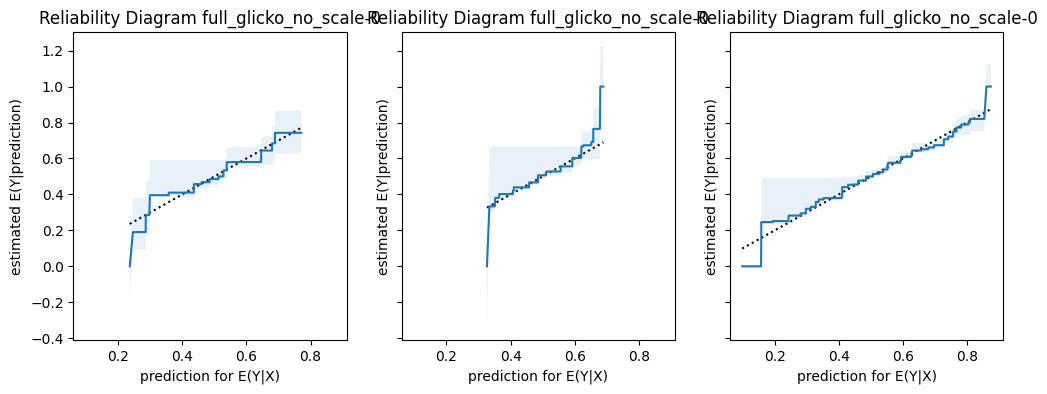

In [24]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from model_diagnostics.calibration import (
    compute_bias,
    plot_bias,
    plot_reliability_diagram,
)

fig, axes = plt.subplots(
    ncols=3,
    nrows=len(pred_test),
    figsize=(12, 4 * len(pred_test)),
    sharex=True,
    sharey=True,
)
mirror_matches = (X_test.character_1 == X_test.character_2).to_numpy()

for i, model_name in enumerate(pred_test):
    elo_pipeline = pipelines[model_name][:-1]
    elo_test = elo_pipeline.transform(X_test)
    near_skill = (
        (
            elo_test["glicko__prob" if "glicko" in model_name else "elo__prob"] - 0.5
        ).abs()
        < 0.02
    ).to_numpy()
    plot_reliability_diagram(
        y_obs=y_test[mirror_matches],
        y_pred=df_pred_test[model_name][mirror_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[0],
    )
    plot_reliability_diagram(
        y_obs=y_test[near_skill],
        y_pred=df_pred_test[model_name][near_skill],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[1],
    )
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[2],
    )

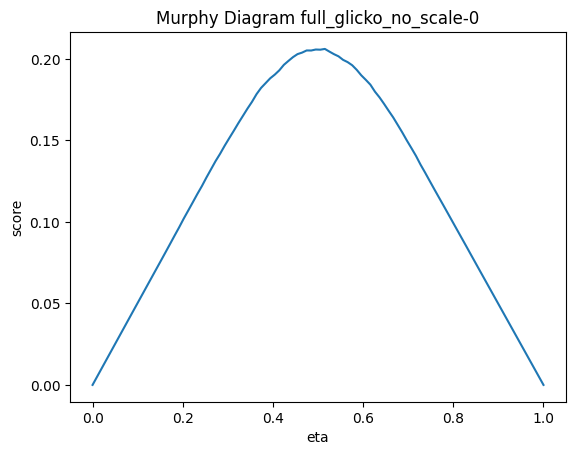

In [25]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [26]:
df_list = []
for model_name in df_pred_test:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""full_glicko_no…",0.000614,0.012151,0.249989,0.238453


In [27]:
import arviz

for model in df_pred_test:
    print(model)
    display(pipelines[model]["model"].data_)
    display(arviz.summary(pipelines[model]["model"].inf_data_))

full_glicko_no_scale-0


,glicko__prob,glicko__r1,glicko__rd1,glicko__v1,glicko__r2,glicko__rd2,glicko__v2,pc_glicko__prob,pc_glicko__r1,pc_glicko__rd1,...,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,render__match_date,render__win,render__public
94542,0.514306,1500.000000,60.000001,0.071000,1489.700093,60.356083,0.071000,0.500000,1500.000000,39.999999,...,DENISOVICH,False,False,valerie-zane,valerie,zane,1,2015-05-09 22:17:03+00:00,False,False
91613,0.605410,1591.024180,40.296652,0.071203,1515.791567,26.768329,0.070416,0.597840,1535.060016,46.127514,...,noshots00,False,False,jaina-setsuki,jaina,setsuki,1,2015-04-26 00:47:35+00:00,True,False
89915,0.578498,1594.659916,40.859152,0.071002,1538.908364,32.559191,0.071024,0.629281,1561.297422,39.060882,...,Legion,False,False,menelker-vendetta,menelker,vendetta,1,2015-04-10 21:46:57+00:00,False,False
71063,0.364425,1436.925569,49.223170,0.071095,1535.788582,47.246921,0.071310,0.478831,1489.139910,45.970800,...,Russellmcc,False,False,jaina-argagarg,jaina,argagarg,1,2014-08-17 16:30:06+00:00,False,False
7180,0.463857,1530.706669,48.294469,0.070995,1556.408810,44.785357,0.070692,0.497614,1517.173333,49.154914,...,lettucemode,False,False,jaina-onimaru,jaina,onimaru,1,2015-08-26 00:00:00+00:00,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73769,0.440508,1536.372984,41.659106,0.071338,1578.604682,40.225186,0.070527,0.531653,1506.153167,39.153166,...,idegoido,False,False,rook-argagarg,rook,argagarg,1,2014-09-11 03:01:45+00:00,False,False
16405,0.346700,1524.265635,55.048554,0.071151,1636.967427,42.257859,0.070825,0.505630,1500.000000,39.999999,...,BD_Corro,False,False,gloria-troq,gloria,troq,1,2017-06-24 00:00:00+00:00,True,True
10484,0.519962,1632.793139,44.906711,0.071014,1618.648258,42.764401,0.069896,0.570352,1491.738137,41.386744,...,CloudCuckooCountry,False,False,persephone-gwen,persephone,gwen,1,2016-03-04 00:00:00+00:00,False,True
92669,0.528087,1523.024151,43.637288,0.071027,1503.225312,27.790330,0.071793,0.497849,1500.000000,39.999999,...,Legion,False,False,bbb-gwen,bbb,gwen,1,2015-05-04 16:46:19+00:00,True,False


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[grave-grave],0.006,0.521,-0.993,1.014,0.006,0.011,8638.0,2552.0,1.0
mu[grave-midori],0.255,0.094,0.081,0.443,0.001,0.001,9249.0,2563.0,1.0
mu[grave-rook],0.055,0.081,-0.102,0.201,0.001,0.001,10204.0,3030.0,1.0
mu[grave-valerie],0.236,0.081,0.084,0.389,0.001,0.001,8944.0,2743.0,1.0
mu[grave-lum],0.065,0.108,-0.143,0.254,0.001,0.002,8884.0,2557.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[persephone-zane],-0.421,0.100,-0.615,-0.241,0.001,0.001,9789.0,2570.0,1.0
mu[gwen-gwen],0.002,0.513,-1.037,0.895,0.005,0.010,9762.0,2698.0,1.0
mu[gwen-zane],-0.351,0.091,-0.524,-0.185,0.001,0.001,10761.0,2527.0,1.0
mu[zane-zane],0.002,0.499,-0.863,0.967,0.005,0.009,10652.0,2961.0,1.0


# Parameter Search

## Sklearn

In [35]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from scipy.stats import loguniform, uniform
from sklearn.model_selection import GridSearchCV

initial_values = [(1500.0, rd, v) for rd in [100, 350, 500] for v in [0.03, 0.06, 0.09]]
pc_init_values = [
    (1500.0, rd, v) for rd in [500, 750, 1000] for v in [0.05, 0.06, 0.07]
]
search = HalvingGridSearchCV(
    pipelines["full_glicko4"],
    {
        "transform__glicko__initial_value": initial_values,
        "transform__pc_glicko__initial_value": initial_values,
    },
    scoring="neg_brier_score",
    verbose=2,
    min_resources="exhaust",
)
search.fit(X_train, y_train)

KeyError: 'full_glicko4'

In [44]:
search.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4]),
 'n_resources': array([ 1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  11

## Hyperactive

In [33]:
from hyperactive import Hyperactive
from hyperactive.optimizers import (
    BayesianOptimizer,
    HillClimbingOptimizer,
    PowellsMethod,
)
import logging

logger = logging.getLogger("hyper")
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig()

pipeline = models["full_glicko_no_scale"].pipeline(
    **parameters["full_glicko_no_scale"][0]
)


def evaluate(params):
    logger.info("Starting evaluation with params %r", {**params})
    pipeline.set_params(
        rating_periods__player__kw_args=dict(
            threshold=params["player_threshold"], field_prefix="player"
        ),
        rating_periods__player_character__kw_args=dict(
            threshold=params["pc_threshold"], field_prefix="player_character"
        ),
        transform__glicko__initial_value=(
            1500.0,
            params["glicko_init_rd"],
            params["glicko_init_v"],
        ),
        transform__pc_glicko__initial_value=(
            1500.0,
            params["pc_glicko_init_rd"],
            params["pc_glicko_init_v"],
        ),
    )
    pipeline.fit(
        X_train,
        y_train,
    )
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=y_pred,
    )
    results = {key: value[0] for key, value in df.to_dict().items()}
    logger.info("Evaluation results %r", results)
    return (1 - results["score"]), results

In [34]:
search_space = dict(
    player_threshold=list(range(1, 20, 1)),
    pc_threshold=list(range(1, 20, 1)),
    glicko_init_rd=list(numpy.arange(10, 700, 10)),
    pc_glicko_init_rd=list(numpy.arange(10, 700, 10)),
    glicko_init_v=list(numpy.arange(0.001, 0.1, 0.001)),
    pc_glicko_init_v=list(numpy.arange(0.001, 0.1, 0.001)),
)

ws = [
    # {
    #     "glicko_init_rd": 30,
    #     "glicko_init_v": 0.09,
    #     "pc_glicko_init_rd": 50,
    #     "pc_glicko_init_v": 0.007,
    #     "glicko_rating_period": 3,
    #     "pc_glicko_rating_period": 3,
    # },
    # {
    #     "glicko_init_rd": 40,
    #     "glicko_init_v": 0.049,
    #     "pc_glicko_init_rd": 110,
    #     "pc_glicko_init_v": 0.081,
    #     "glicko_rating_period": 7,
    #     "pc_glicko_rating_period": 14,
    # },
    # {
    #     "glicko_init_rd": 30,
    #     "glicko_init_v": 0.09,
    #     "pc_glicko_init_rd": 50,
    #     "pc_glicko_init_v": 0.007,
    #     "glicko_rating_period": 2,
    #     "pc_glicko_rating_period": 2,
    # },
    {
        "player_threshold": 10,
        "pc_threshold": 10,
        "glicko_init_rd": 60,
        "pc_glicko_init_rd": 40,
        "glicko_init_v": 0.059,
        "pc_glicko_init_v": 0.027,
    }
]

hyper = Hyperactive()
bayes = BayesianOptimizer(
    # warm_start_smbo=search_data
)
hill = HillClimbingOptimizer(epsilon=0.1)
powell = PowellsMethod()
hyper.add_search(
    evaluate,
    search_space,
    n_iter=70,
    optimizer=powell,
    initialize={
        "warm_start": ws,
        # "random": 5
    },
)
hyper.run()

[0] evaluate (Powell's Method):   0%|                                                                                                                                                                                                                                                                                               | 0/70 [00:00<?, ?it/s]2023-11-01 07:41:26 INFO     Starting evaluation with params {'player_threshold': 10, 'pc_threshold': 10, 'glicko_init_rd': 60, 'pc_glicko_init_rd': 40, 'glicko_init_v': 0.059000000000000004, 'pc_glicko_init_v': 0.027000000000000003}
2023-11-01 07:42:13 INFO     Starting Glicko2Estimator.fit
2023-11-01 07:42:21 INFO     Ending Glicko2Estimator.fit
2023-11-01 07:42:21 INFO     Starting Glicko2Estimator.transform
2023-11-01 07:42:21 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 07:42:22 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 07:42:24 INFO     Restacking columns in Glicko2Estimator.transform


Compiling...
Compilation time =  0:00:03.281867
Sampling...
Sampling time =  0:00:05.525510
Transforming variables...
Transformation time =  0:03:00.273571


2023-11-01 07:48:13 INFO     Starting Glicko2Estimator.transform
2023-11-01 07:48:13 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 07:48:14 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 07:48:14 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 07:48:14 INFO     Ending Glicko2Estimator.transform
2023-11-01 07:48:14 INFO     Starting Glicko2Estimator.transform
2023-11-01 07:48:14 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 07:48:14 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 07:48:15 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 07:48:15 INFO     Ending Glicko2Estimator.transform
2023-11-01 07:48:15 INFO     Starting _transform_min_games
2023-11-01 07:48:15 INFO     Ending _transform_min_games
2023-11-01 07:48:15 INFO     Starting _transform_matchup
2023-11-01 07:48:28 INFO     Ending _transform_matchup
2023-11-01 07:48:28 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.398534
Sampling...
Sampling time =  0:00:05.405986
Transforming variables...
Transformation time =  0:02:35.765882


2023-11-01 07:54:47 INFO     Starting Glicko2Estimator.transform
2023-11-01 07:54:47 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 07:54:48 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 07:54:49 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 07:54:49 INFO     Ending Glicko2Estimator.transform
2023-11-01 07:54:49 INFO     Starting Glicko2Estimator.transform
2023-11-01 07:54:49 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 07:54:49 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 07:54:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 07:54:50 INFO     Ending Glicko2Estimator.transform
2023-11-01 07:54:50 INFO     Starting _transform_min_games
2023-11-01 07:54:50 INFO     Ending _transform_min_games
2023-11-01 07:54:50 INFO     Starting _transform_matchup
2023-11-01 07:55:02 INFO     Ending _transform_matchup
2023-11-01 07:55:02 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.330767
Sampling...
Sampling time =  0:00:05.434779
Transforming variables...
Transformation time =  0:02:34.711276


2023-11-01 08:01:12 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:01:12 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:01:13 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:01:13 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:01:13 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:01:13 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:01:13 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:01:13 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:01:14 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:01:14 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:01:14 INFO     Starting _transform_min_games
2023-11-01 08:01:14 INFO     Ending _transform_min_games
2023-11-01 08:01:14 INFO     Starting _transform_matchup
2023-11-01 08:01:27 INFO     Ending _transform_matchup
2023-11-01 08:01:27 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.146599
Sampling...
Sampling time =  0:00:05.721716
Transforming variables...
Transformation time =  0:03:07.019958


2023-11-01 08:08:09 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:08:10 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:08:10 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:08:11 INFO     Starting _transform_min_games
2023-11-01 08:08:11 INFO     Ending _transform_min_games
2023-11-01 08:08:11 INFO     Starting _transform_matchup
2023-11-01 08:08:23 INFO     Ending _transform_matchup
2023-11-01 08:08:23 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.395250
Sampling...
Sampling time =  0:00:05.293185
Transforming variables...
Transformation time =  0:02:38.019159


2023-11-01 08:14:36 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:14:36 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:14:37 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:14:38 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:14:38 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:14:38 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:14:38 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:14:39 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:14:39 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:14:39 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:14:39 INFO     Starting _transform_min_games
2023-11-01 08:14:39 INFO     Ending _transform_min_games
2023-11-01 08:14:39 INFO     Starting _transform_matchup
2023-11-01 08:14:51 INFO     Ending _transform_matchup
2023-11-01 08:14:51 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.236133
Sampling...
Sampling time =  0:00:05.728428
Transforming variables...
Transformation time =  0:03:00.490373


2023-11-01 08:21:28 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:21:28 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:21:28 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:21:29 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:21:29 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:21:29 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:21:29 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:21:30 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:21:30 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:21:30 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:21:30 INFO     Starting _transform_min_games
2023-11-01 08:21:30 INFO     Ending _transform_min_games
2023-11-01 08:21:30 INFO     Starting _transform_matchup
2023-11-01 08:21:43 INFO     Ending _transform_matchup
2023-11-01 08:21:43 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.533627
Sampling...
Sampling time =  0:00:05.416816
Transforming variables...
Transformation time =  0:02:32.553367


2023-11-01 08:28:33 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:28:33 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:28:34 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:28:35 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:28:35 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:28:35 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:28:35 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:28:36 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:28:36 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:28:36 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:28:36 INFO     Starting _transform_min_games
2023-11-01 08:28:36 INFO     Ending _transform_min_games
2023-11-01 08:28:36 INFO     Starting _transform_matchup
2023-11-01 08:28:47 INFO     Ending _transform_matchup
2023-11-01 08:28:47 INFO     Evaluation 

Compiling...
Compilation time =  0:00:01.380278
Sampling...
Sampling time =  0:00:05.048678
Transforming variables...
Transformation time =  0:02:10.344405


2023-11-01 08:37:27 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:37:27 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:37:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:37:31 INFO     Starting _transform_min_games
2023-11-01 08:37:31 INFO     Ending _transform_min_games
2023-11-01 08:37:31 INFO     Starting _transform_matchup
2023-11-01 08:37:43 INFO     Ending _transform_matchup
2023-11-01 08:37:43 INFO     Evaluation 

Compiling...
Compilation time =  0:00:01.354297
Sampling...
Sampling time =  0:00:05.024421
Transforming variables...
Transformation time =  0:02:10.865769


2023-11-01 08:46:26 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:46:26 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:46:27 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:46:29 INFO     Starting _transform_min_games
2023-11-01 08:46:29 INFO     Ending _transform_min_games
2023-11-01 08:46:29 INFO     Starting _transform_matchup
2023-11-01 08:46:42 INFO     Ending _transform_matchup
2023-11-01 08:46:42 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.869633
Sampling...
Sampling time =  0:00:05.812739
Transforming variables...
Transformation time =  0:03:01.401743


2023-11-01 08:52:27 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:52:27 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:52:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:52:30 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:52:30 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:52:30 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:52:30 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:52:31 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:52:32 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:52:32 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:52:32 INFO     Starting _transform_min_games
2023-11-01 08:52:32 INFO     Ending _transform_min_games
2023-11-01 08:52:32 INFO     Starting _transform_matchup
2023-11-01 08:52:44 INFO     Ending _transform_matchup
2023-11-01 08:52:44 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.382590
Sampling...
Sampling time =  0:00:05.612802
Transforming variables...
Transformation time =  0:03:01.941642


2023-11-01 08:58:31 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:58:31 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:58:32 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:58:34 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:58:34 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:58:34 INFO     Starting Glicko2Estimator.transform
2023-11-01 08:58:34 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 08:58:34 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 08:58:36 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 08:58:36 INFO     Ending Glicko2Estimator.transform
2023-11-01 08:58:36 INFO     Starting _transform_min_games
2023-11-01 08:58:36 INFO     Ending _transform_min_games
2023-11-01 08:58:36 INFO     Starting _transform_matchup
2023-11-01 08:58:48 INFO     Ending _transform_matchup
2023-11-01 08:58:48 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.990399
Sampling...
Sampling time =  0:00:05.665765
Transforming variables...
Transformation time =  0:02:57.871923


2023-11-01 09:04:31 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:04:31 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:04:33 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:04:34 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:04:34 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:04:34 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:04:34 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:04:35 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:04:36 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:04:36 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:04:36 INFO     Starting _transform_min_games
2023-11-01 09:04:36 INFO     Ending _transform_min_games
2023-11-01 09:04:36 INFO     Starting _transform_matchup
2023-11-01 09:04:48 INFO     Ending _transform_matchup
2023-11-01 09:04:48 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.436071
Sampling...
Sampling time =  0:00:05.619497
Transforming variables...
Transformation time =  0:02:59.990554


2023-11-01 09:10:33 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:10:33 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:10:35 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:10:37 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:10:37 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:10:37 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:10:38 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:10:38 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:10:39 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:10:39 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:10:39 INFO     Starting _transform_min_games
2023-11-01 09:10:39 INFO     Ending _transform_min_games
2023-11-01 09:10:39 INFO     Starting _transform_matchup
2023-11-01 09:10:51 INFO     Ending _transform_matchup
2023-11-01 09:10:51 INFO     Evaluation 

Compiling...
Compilation time =  0:00:04.031501
Sampling...
Sampling time =  0:00:05.613054
Transforming variables...
Transformation time =  0:02:57.290158


2023-11-01 09:16:36 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:16:36 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:16:37 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:16:39 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:16:39 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:16:39 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:16:39 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:16:39 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:16:40 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:16:40 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:16:40 INFO     Starting _transform_min_games
2023-11-01 09:16:40 INFO     Ending _transform_min_games
2023-11-01 09:16:40 INFO     Starting _transform_matchup
2023-11-01 09:16:53 INFO     Ending _transform_matchup
2023-11-01 09:16:53 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.505083
Sampling...
Sampling time =  0:00:05.598463
Transforming variables...
Transformation time =  0:02:50.034930


2023-11-01 09:22:26 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:22:26 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:22:28 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:22:29 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:22:29 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:22:29 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:22:29 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:22:30 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:22:31 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:22:31 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:22:31 INFO     Starting _transform_min_games
2023-11-01 09:22:31 INFO     Ending _transform_min_games
2023-11-01 09:22:31 INFO     Starting _transform_matchup
2023-11-01 09:22:42 INFO     Ending _transform_matchup
2023-11-01 09:22:42 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.333138
Sampling...
Sampling time =  0:00:05.394111
Transforming variables...
Transformation time =  0:02:40.828855


2023-11-01 09:28:05 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:28:05 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:28:07 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:28:08 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:28:08 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:28:08 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:28:08 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:28:09 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:28:09 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:28:09 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:28:09 INFO     Starting _transform_min_games
2023-11-01 09:28:09 INFO     Ending _transform_min_games
2023-11-01 09:28:09 INFO     Starting _transform_matchup
2023-11-01 09:28:22 INFO     Ending _transform_matchup
2023-11-01 09:28:22 INFO     Evaluation 

Compiling...
Compilation time =  0:00:04.042551
Sampling...
Sampling time =  0:00:05.865578
Transforming variables...
Transformation time =  0:03:47.628274


2023-11-01 09:35:02 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:35:02 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:35:04 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:35:05 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:35:05 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:35:05 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:35:05 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:35:06 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:35:07 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:35:07 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:35:07 INFO     Starting _transform_min_games
2023-11-01 09:35:07 INFO     Ending _transform_min_games
2023-11-01 09:35:07 INFO     Starting _transform_matchup
2023-11-01 09:35:18 INFO     Ending _transform_matchup
2023-11-01 09:35:18 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.439597
Sampling...
Sampling time =  0:00:05.472412
Transforming variables...
Transformation time =  0:03:29.554996


2023-11-01 09:41:31 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:41:31 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:41:33 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:41:34 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:41:34 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:41:34 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:41:34 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:41:35 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:41:35 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:41:35 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:41:35 INFO     Starting _transform_min_games
2023-11-01 09:41:35 INFO     Ending _transform_min_games
2023-11-01 09:41:35 INFO     Starting _transform_matchup
2023-11-01 09:41:47 INFO     Ending _transform_matchup
2023-11-01 09:41:47 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.345095
Sampling...
Sampling time =  0:00:06.087421
Transforming variables...
Transformation time =  0:02:33.877219


2023-11-01 09:47:00 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:47:00 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:47:01 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:47:03 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:47:03 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:47:03 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:47:03 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:47:03 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:47:04 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:47:04 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:47:04 INFO     Starting _transform_min_games
2023-11-01 09:47:04 INFO     Ending _transform_min_games
2023-11-01 09:47:04 INFO     Starting _transform_matchup
2023-11-01 09:47:15 INFO     Ending _transform_matchup
2023-11-01 09:47:15 INFO     Evaluation 

Compiling...
Compilation time =  0:00:13.224914
Sampling...
Sampling time =  0:00:05.298975
Transforming variables...
Transformation time =  0:00:09.707189


2023-11-01 09:50:14 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:50:15 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:50:16 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:50:18 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:50:18 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:50:18 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:50:18 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:50:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:50:19 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:50:19 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:50:19 INFO     Starting _transform_min_games
2023-11-01 09:50:19 INFO     Ending _transform_min_games
2023-11-01 09:50:19 INFO     Starting _transform_matchup
2023-11-01 09:50:30 INFO     Ending _transform_matchup
2023-11-01 09:50:30 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.378970
Sampling...
Sampling time =  0:00:05.330753
Transforming variables...
Transformation time =  0:02:47.260648


2023-11-01 09:56:02 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:56:02 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:56:03 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:56:05 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:56:05 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:56:05 INFO     Starting Glicko2Estimator.transform
2023-11-01 09:56:05 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 09:56:05 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 09:56:06 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 09:56:06 INFO     Ending Glicko2Estimator.transform
2023-11-01 09:56:06 INFO     Starting _transform_min_games
2023-11-01 09:56:06 INFO     Ending _transform_min_games
2023-11-01 09:56:06 INFO     Starting _transform_matchup
2023-11-01 09:56:18 INFO     Ending _transform_matchup
2023-11-01 09:56:18 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.449666
Sampling...
Sampling time =  0:00:05.275961
Transforming variables...
Transformation time =  0:02:37.753442


2023-11-01 10:01:36 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:01:36 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:01:38 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:01:39 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:01:39 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:01:39 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:01:39 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:01:40 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:01:40 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:01:40 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:01:40 INFO     Starting _transform_min_games
2023-11-01 10:01:40 INFO     Ending _transform_min_games
2023-11-01 10:01:40 INFO     Starting _transform_matchup
2023-11-01 10:01:52 INFO     Ending _transform_matchup
2023-11-01 10:01:52 INFO     Evaluation 

Compiling...
Compilation time =  0:00:13.607254
Sampling...
Sampling time =  0:00:05.332573
Transforming variables...
Transformation time =  0:00:09.820495


2023-11-01 10:04:56 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:04:56 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:04:57 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:04:59 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:04:59 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:04:59 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:04:59 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:04:59 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:05:00 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:05:00 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:05:00 INFO     Starting _transform_min_games
2023-11-01 10:05:00 INFO     Ending _transform_min_games
2023-11-01 10:05:00 INFO     Starting _transform_matchup
2023-11-01 10:05:12 INFO     Ending _transform_matchup
2023-11-01 10:05:12 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.630127
Sampling...
Sampling time =  0:00:05.310584
Transforming variables...
Transformation time =  0:03:18.266299


2023-11-01 10:11:14 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:11:14 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:11:16 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:11:17 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:11:17 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:11:17 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:11:17 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:11:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:11:18 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:11:18 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:11:18 INFO     Starting _transform_min_games
2023-11-01 10:11:18 INFO     Ending _transform_min_games
2023-11-01 10:11:18 INFO     Starting _transform_matchup
2023-11-01 10:11:30 INFO     Ending _transform_matchup
2023-11-01 10:11:30 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.477420
Sampling...
Sampling time =  0:00:05.392376
Transforming variables...
Transformation time =  0:02:34.042787


2023-11-01 10:16:46 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:16:46 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:16:48 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:16:49 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:16:49 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:16:49 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:16:49 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:16:50 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:16:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:16:50 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:16:50 INFO     Starting _transform_min_games
2023-11-01 10:16:50 INFO     Ending _transform_min_games
2023-11-01 10:16:50 INFO     Starting _transform_matchup
2023-11-01 10:17:03 INFO     Ending _transform_matchup
2023-11-01 10:17:03 INFO     Evaluation 

Compiling...
Compilation time =  0:00:02.541636
Sampling...
Sampling time =  0:00:06.379969
Transforming variables...
Transformation time =  0:02:31.803265


2023-11-01 10:22:18 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:22:18 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:22:19 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:22:21 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:22:21 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:22:21 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:22:21 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:22:21 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:22:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:22:22 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:22:22 INFO     Starting _transform_min_games
2023-11-01 10:22:22 INFO     Ending _transform_min_games
2023-11-01 10:22:22 INFO     Starting _transform_matchup
2023-11-01 10:22:33 INFO     Ending _transform_matchup
2023-11-01 10:22:33 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.477556
Sampling...
Sampling time =  0:00:05.268852
Transforming variables...
Transformation time =  0:02:32.351381


2023-11-01 10:27:47 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:27:47 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:27:49 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:27:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:27:50 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:27:50 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:27:50 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:27:51 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:27:51 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:27:51 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:27:52 INFO     Starting _transform_min_games
2023-11-01 10:27:52 INFO     Ending _transform_min_games
2023-11-01 10:27:52 INFO     Starting _transform_matchup
2023-11-01 10:28:03 INFO     Ending _transform_matchup
2023-11-01 10:28:03 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.507825
Sampling...
Sampling time =  0:00:05.342043
Transforming variables...
Transformation time =  0:02:32.814257


2023-11-01 10:33:18 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:33:18 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:33:19 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:33:21 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:33:21 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:33:21 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:33:21 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:33:21 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:33:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:33:22 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:33:22 INFO     Starting _transform_min_games
2023-11-01 10:33:22 INFO     Ending _transform_min_games
2023-11-01 10:33:22 INFO     Starting _transform_matchup
2023-11-01 10:33:33 INFO     Ending _transform_matchup
2023-11-01 10:33:33 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.516978
Sampling...
Sampling time =  0:00:05.489024
Transforming variables...
Transformation time =  0:02:34.352073


2023-11-01 10:38:50 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:38:50 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:38:51 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:38:53 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:38:53 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:38:53 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:38:53 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:38:53 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:38:54 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:38:54 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:38:54 INFO     Starting _transform_min_games
2023-11-01 10:38:54 INFO     Ending _transform_min_games
2023-11-01 10:38:54 INFO     Starting _transform_matchup
2023-11-01 10:39:07 INFO     Ending _transform_matchup
2023-11-01 10:39:07 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.545925
Sampling...
Sampling time =  0:00:05.235731
Transforming variables...
Transformation time =  0:02:31.778714


2023-11-01 10:44:17 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:44:17 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:44:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:44:20 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:44:20 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:44:20 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:44:21 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:44:21 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:44:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:44:22 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:44:22 INFO     Starting _transform_min_games
2023-11-01 10:44:22 INFO     Ending _transform_min_games
2023-11-01 10:44:22 INFO     Starting _transform_matchup
2023-11-01 10:44:33 INFO     Ending _transform_matchup
2023-11-01 10:44:33 INFO     Evaluation 

Compiling...
Compilation time =  0:00:04.272051
Sampling...
Sampling time =  0:00:05.308296
Transforming variables...
Transformation time =  0:02:33.942855


2023-11-01 10:49:47 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:49:47 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:49:49 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:49:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:49:50 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:49:50 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:49:50 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:49:51 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:49:51 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:49:51 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:49:51 INFO     Starting _transform_min_games
2023-11-01 10:49:51 INFO     Ending _transform_min_games
2023-11-01 10:49:51 INFO     Starting _transform_matchup
2023-11-01 10:50:03 INFO     Ending _transform_matchup
2023-11-01 10:50:03 INFO     Evaluation 

Compiling...
Compilation time =  0:00:02.554367
Sampling...
Sampling time =  0:00:06.404694
Transforming variables...
Transformation time =  0:02:32.171323


2023-11-01 10:55:17 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:55:17 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:55:19 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:55:20 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:55:20 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:55:20 INFO     Starting Glicko2Estimator.transform
2023-11-01 10:55:20 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 10:55:21 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 10:55:21 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 10:55:21 INFO     Ending Glicko2Estimator.transform
2023-11-01 10:55:21 INFO     Starting _transform_min_games
2023-11-01 10:55:21 INFO     Ending _transform_min_games
2023-11-01 10:55:21 INFO     Starting _transform_matchup
2023-11-01 10:55:33 INFO     Ending _transform_matchup
2023-11-01 10:55:33 INFO     Evaluation 

Compiling...
Compilation time =  0:00:02.514739
Sampling...
Sampling time =  0:00:05.261141
Transforming variables...
Transformation time =  0:02:30.733449


2023-11-01 11:00:46 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:00:47 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:00:48 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:00:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:00:50 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:00:50 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:00:50 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:00:51 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:00:51 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:00:51 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:00:51 INFO     Starting _transform_min_games
2023-11-01 11:00:51 INFO     Ending _transform_min_games
2023-11-01 11:00:51 INFO     Starting _transform_matchup
2023-11-01 11:01:03 INFO     Ending _transform_matchup
2023-11-01 11:01:03 INFO     Evaluation 

Compiling...
Compilation time =  0:00:04.529098
Sampling...
Sampling time =  0:00:05.330156
Transforming variables...
Transformation time =  0:02:32.892679


2023-11-01 11:06:18 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:06:18 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:06:19 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:06:21 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:06:21 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:06:21 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:06:21 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:06:21 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:06:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:06:22 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:06:22 INFO     Starting _transform_min_games
2023-11-01 11:06:22 INFO     Ending _transform_min_games
2023-11-01 11:06:22 INFO     Starting _transform_matchup
2023-11-01 11:06:33 INFO     Ending _transform_matchup
2023-11-01 11:06:33 INFO     Evaluation 

Compiling...
Compilation time =  0:00:02.551973
Sampling...
Sampling time =  0:00:05.332386
Transforming variables...
Transformation time =  0:02:33.573244


2023-11-01 11:11:48 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:11:49 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:11:50 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:11:52 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:11:52 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:11:52 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:11:52 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:11:52 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:11:53 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:11:53 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:11:53 INFO     Starting _transform_min_games
2023-11-01 11:11:53 INFO     Ending _transform_min_games
2023-11-01 11:11:53 INFO     Starting _transform_matchup
2023-11-01 11:12:04 INFO     Ending _transform_matchup
2023-11-01 11:12:04 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.578150
Sampling...
Sampling time =  0:00:05.259315
Transforming variables...
Transformation time =  0:02:31.422931


2023-11-01 11:17:16 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:17:17 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:17:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:17:20 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:17:20 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:17:20 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:17:20 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:17:20 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:17:21 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:17:21 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:17:21 INFO     Starting _transform_min_games
2023-11-01 11:17:21 INFO     Ending _transform_min_games
2023-11-01 11:17:21 INFO     Starting _transform_matchup
2023-11-01 11:17:33 INFO     Ending _transform_matchup
2023-11-01 11:17:33 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.623204
Sampling...
Sampling time =  0:00:05.335412
Transforming variables...
Transformation time =  0:02:33.412658


2023-11-01 11:22:46 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:22:47 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:22:49 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:22:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:22:50 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:22:50 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:22:50 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:22:51 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:22:51 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:22:51 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:22:51 INFO     Starting _transform_min_games
2023-11-01 11:22:51 INFO     Ending _transform_min_games
2023-11-01 11:22:51 INFO     Starting _transform_matchup
2023-11-01 11:23:03 INFO     Ending _transform_matchup
2023-11-01 11:23:03 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.610548
Sampling...
Sampling time =  0:00:05.283991
Transforming variables...
Transformation time =  0:02:38.063227


2023-11-01 11:28:22 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:28:22 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:28:23 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:28:25 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:28:25 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:28:25 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:28:25 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:28:25 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:28:26 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:28:26 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:28:26 INFO     Starting _transform_min_games
2023-11-01 11:28:26 INFO     Ending _transform_min_games
2023-11-01 11:28:26 INFO     Starting _transform_matchup
2023-11-01 11:28:39 INFO     Ending _transform_matchup
2023-11-01 11:28:39 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.832550
Sampling...
Sampling time =  0:00:05.580885
Transforming variables...
Transformation time =  0:02:46.991594


2023-11-01 11:34:13 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:34:13 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:34:14 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:34:16 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:34:16 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:34:16 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:34:16 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:34:17 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:34:17 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:34:17 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:34:18 INFO     Starting _transform_min_games
2023-11-01 11:34:18 INFO     Ending _transform_min_games
2023-11-01 11:34:18 INFO     Starting _transform_matchup
2023-11-01 11:34:30 INFO     Ending _transform_matchup
2023-11-01 11:34:30 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.772645
Sampling...
Sampling time =  0:00:08.254671
Transforming variables...
Transformation time =  0:03:17.914277


2023-11-01 11:41:08 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:41:08 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:41:09 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:41:11 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:41:11 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:41:11 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:41:13 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:41:13 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:41:14 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:41:14 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:41:14 INFO     Starting _transform_min_games
2023-11-01 11:41:14 INFO     Ending _transform_min_games
2023-11-01 11:41:14 INFO     Starting _transform_matchup
2023-11-01 11:41:26 INFO     Ending _transform_matchup
2023-11-01 11:41:26 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.937461
Sampling...
Sampling time =  0:00:06.037974
Transforming variables...
Transformation time =  0:03:04.339053


2023-11-01 11:47:19 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:47:19 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:47:21 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:47:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:47:22 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:47:22 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:47:22 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:47:23 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:47:24 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:47:24 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:47:24 INFO     Starting _transform_min_games
2023-11-01 11:47:24 INFO     Ending _transform_min_games
2023-11-01 11:47:24 INFO     Starting _transform_matchup
2023-11-01 11:47:36 INFO     Ending _transform_matchup
2023-11-01 11:47:36 INFO     Evaluation 

Compiling...
Compilation time =  0:00:02.926244
Sampling...
Sampling time =  0:00:07.841987
Transforming variables...
Transformation time =  0:02:48.895166


2023-11-01 11:53:23 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:53:23 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:53:25 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:53:27 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:53:27 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:53:27 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:53:27 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:53:28 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:53:28 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:53:28 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:53:28 INFO     Starting _transform_min_games
2023-11-01 11:53:28 INFO     Ending _transform_min_games
2023-11-01 11:53:28 INFO     Starting _transform_matchup
2023-11-01 11:53:40 INFO     Ending _transform_matchup
2023-11-01 11:53:40 INFO     Evaluation 

Compiling...
Compilation time =  0:00:04.153740
Sampling...
Sampling time =  0:00:05.893593
Transforming variables...
Transformation time =  0:03:04.384755


2023-11-01 11:59:43 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:59:43 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:59:44 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:59:46 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:59:46 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:59:46 INFO     Starting Glicko2Estimator.transform
2023-11-01 11:59:46 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 11:59:47 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 11:59:48 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 11:59:48 INFO     Ending Glicko2Estimator.transform
2023-11-01 11:59:48 INFO     Starting _transform_min_games
2023-11-01 11:59:48 INFO     Ending _transform_min_games
2023-11-01 11:59:48 INFO     Starting _transform_matchup
2023-11-01 12:00:03 INFO     Ending _transform_matchup
2023-11-01 12:00:03 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.865551
Sampling...
Sampling time =  0:00:05.328929
Transforming variables...
Transformation time =  0:03:19.575441


2023-11-01 12:06:15 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:06:15 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:06:17 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:06:19 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:06:19 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:06:19 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:06:19 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:06:20 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:06:20 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:06:20 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:06:20 INFO     Starting _transform_min_games
2023-11-01 12:06:20 INFO     Ending _transform_min_games
2023-11-01 12:06:20 INFO     Starting _transform_matchup
2023-11-01 12:06:32 INFO     Ending _transform_matchup
2023-11-01 12:06:32 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.833254
Sampling...
Sampling time =  0:00:05.496238
Transforming variables...
Transformation time =  0:02:36.686939


2023-11-01 12:11:45 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:11:45 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:11:46 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:11:46 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:11:46 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:11:46 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:11:46 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:11:47 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:11:47 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:11:47 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:11:47 INFO     Starting _transform_min_games
2023-11-01 12:11:47 INFO     Ending _transform_min_games
2023-11-01 12:11:47 INFO     Starting _transform_matchup
2023-11-01 12:11:59 INFO     Ending _transform_matchup
2023-11-01 12:11:59 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.639630
Sampling...
Sampling time =  0:00:05.312611
Transforming variables...
Transformation time =  0:02:36.780089


2023-11-01 12:17:12 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:17:13 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:17:13 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:17:14 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:17:14 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:17:14 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:17:14 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:17:14 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:17:15 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:17:15 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:17:15 INFO     Starting _transform_min_games
2023-11-01 12:17:15 INFO     Ending _transform_min_games
2023-11-01 12:17:15 INFO     Starting _transform_matchup
2023-11-01 12:17:26 INFO     Ending _transform_matchup
2023-11-01 12:17:26 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.769808
Sampling...
Sampling time =  0:00:05.282773
Transforming variables...
Transformation time =  0:03:17.100986


2023-11-01 12:23:31 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:23:31 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:23:31 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:23:32 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:23:32 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:23:32 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:23:32 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:23:33 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:23:34 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:23:34 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:23:34 INFO     Starting _transform_min_games
2023-11-01 12:23:34 INFO     Ending _transform_min_games
2023-11-01 12:23:34 INFO     Starting _transform_matchup
2023-11-01 12:23:47 INFO     Ending _transform_matchup
2023-11-01 12:23:47 INFO     Evaluation 

Compiling...
Compilation time =  0:00:04.098338
Sampling...
Sampling time =  0:00:06.353264
Transforming variables...
Transformation time =  0:03:27.332198


2023-11-01 12:30:24 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:30:24 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:30:26 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:30:28 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:30:28 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:30:28 INFO     Starting Glicko2Estimator.transform
2023-11-01 12:30:29 INFO     Computing probabilities in Glicko2Estimator.transform
2023-11-01 12:30:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-11-01 12:30:30 INFO     Restacking columns in Glicko2Estimator.transform
2023-11-01 12:30:30 INFO     Ending Glicko2Estimator.transform
2023-11-01 12:30:30 INFO     Starting _transform_min_games
2023-11-01 12:30:30 INFO     Ending _transform_min_games
2023-11-01 12:30:30 INFO     Starting _transform_matchup
2023-11-01 12:30:42 INFO     Ending _transform_matchup
2023-11-01 12:30:42 INFO     Evaluation 



Results: 'evaluate'  
   Best score: 0.7631384741079819  
   Best additional results:
      'discrimination' : 0.013637457004856718  
      'miscalibration' : 0.0005307421567844195  
      'uncertainty'    : 0.24996824074009047  
   Best parameter set:
      'player_threshold'  : 1.0  
      'pc_threshold'      : 3.0  
      'glicko_init_rd'    : 60.0  
      'pc_glicko_init_rd' : 40.0  
      'glicko_init_v'     : 0.07100000000000001  
      'pc_glicko_init_v'  : 0.084  
   Best iteration: 0  
 
   Random seed: 1125914049  
 
   Evaluation time   : 17355.50676894188 sec    [100.0 %]
   Optimization time : 0.03179168701171875 sec    [0.0 %]
   Iteration time    : 17355.53856062889 sec    [247.94 sec/iter]
 


In [35]:
search_data = hyper.search_data(evaluate)

In [36]:
pandas.concat([search_data, hyper.search_data(evaluate)]).sort_values("score")

,player_threshold,pc_threshold,glicko_init_rd,pc_glicko_init_rd,glicko_init_v,pc_glicko_init_v,discrimination,miscalibration,score,uncertainty
35,4,3,60,590,0.059,0.027,0.006007,0.005389,0.750649,0.249968
35,4,3,60,590,0.059,0.027,0.006007,0.005389,0.750649,0.249968
32,4,3,60,520,0.059,0.027,0.006725,0.004681,0.752076,0.249968
32,4,3,60,520,0.059,0.027,0.006725,0.004681,0.752076,0.249968
2,19,10,60,40,0.059,0.027,0.011111,0.000509,0.760634,0.249968
...,...,...,...,...,...,...,...,...,...,...
67,1,3,60,40,0.071,0.084,0.013637,0.000531,0.763138,0.249968
66,1,3,60,40,0.071,0.084,0.013637,0.000531,0.763138,0.249968
61,1,3,60,40,0.071,0.084,0.013637,0.000531,0.763138,0.249968
61,1,3,60,40,0.071,0.084,0.013637,0.000531,0.763138,0.249968


# Cross Validation

In [ ]:
import arviz
arviz.plot_pair(models['full'].inf_data_, var_names=['pc_elo_sum_intercept', 'elo_sum_intercept']

In [ ]:
scores = cross_validate(
    pipelines['full_glicko'],
    X_train,
    y=y_train,
    # fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
games.groupby('min_games__player_1_orig').count() + games.groupby('min_games__player_2_orig')

In [97]:
pandas.Series([0, 1500]).std()

1060.6601717798212